In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017
from CICIDS2017.analysis.features import recompute_features

from scripts.models.pytorch.MLP import NetworkIntrusionMLP

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

from NIDS_attacks.fgsm import attack_fgsm
from NIDS_attacks.bounds_constrains import apply_bounds_constraints
from NIDS_attacks.integers_constrains import apply_integer_constraints

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    root_dir=root_dir,
    log_name="ADV_ATT_FGSM_MLP_CICIDS2017",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-26 16:06:25,988 - INFO - Logger initialized for 'ADV_ATT_FGSM_MLP_CICIDS2017_20251126_160625'
2025-11-26 16:06:25,989 - INFO - Using device: cuda:0


In [2]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label")

dataset = full_dataset.subset(size=900*1000, multi_class=True)

X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=False,
    to_tensor=True
)

# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

2025-11-26 16:06:25,997 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-26 16:06:26,512 - INFO - Loading dataset into DataFrame
2025-11-26 16:06:39,932 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-26 16:06:55,646 - INFO - ============================================================
2025-11-26 16:06:55,647 - INFO - Preprocessing completed successfully
2025-11-26 16:06:55,648 - INFO - Final dimensions: 1,940,693 rows x 71 columns
2025-11-26 16:06:55,648 - INFO - Total rows removed: 273,776 (12.36%)
2025-11-26 16:06:55,649 - INFO - data retention rate: 87.64%
2025-11-26 16:06:55,649 - INFO - ============================================================
2025-11-26 16:06:55,651 - INFO - Optimizing memory usage of the dataset...
2025-11-26 16:06:55,653 - INFO - Initial memory usage: 1066.05 MB
2025-11-26 16:06:56,330 - INFO - Optimized memory usage: 555.24 MB
2025-11-26 16:06:56,330 - INFO - Memory reduction: 510.82 MB (47.92%)
20

In [4]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input Size: {input_size}, Num Classes: {num_classes}")

model_mlp = NetworkIntrusionMLP(
    input_size=input_size,
    layer_features=[128, 64, 32],
    layer_classifier=[16],
    num_classes=num_classes,
    device=device
)
model_mlp = model_mlp.load_model(f"{root_dir}/NIDS_attacks/pretrained_models/MLP{input_size}x{num_classes}.400.pt")

Input Size: 70, Num Classes: 4


2025-11-26 16:09:50,035 - INFO - Running analysis for PyTorch model: MLP - CICIDS2017 - Before Attack on device: cuda:0


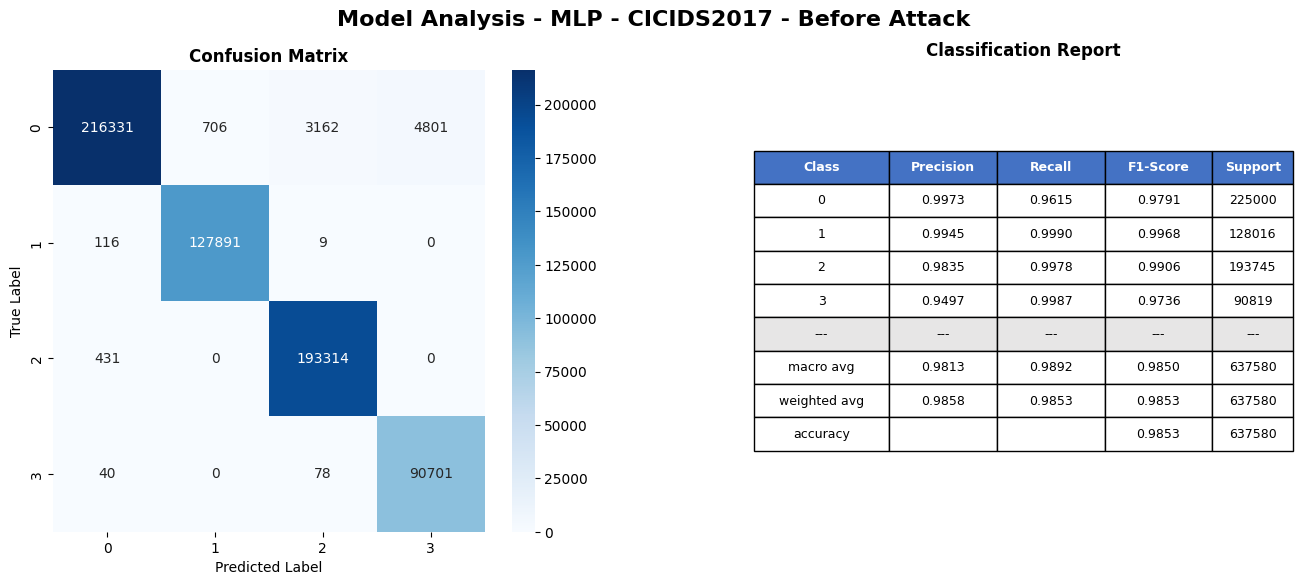

In [5]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=torch.vstack((X_train, X_val)),
    y_test=torch.vstack((y_train, y_val)),
    logger=logger,
    root_dir=root_dir,
    title="MLP - CICIDS2017 - Before Attack",
    plot=True,
    device=device
)

In [6]:
# Let's define our adversarial input: 
# it is a copy of our original input, and we will need to be able to compute the gradient with respect to that input

attack_indices = dataset.is_attack[dataset.is_attack == 1].index.tolist()
random_idx = torch.randperm(len(attack_indices))[:10]

adversarial_attack_input = dataset.features.iloc[attack_indices].iloc[random_idx].values.astype('float32')

# To Tensor
adversarial_attack_input = torch.FloatTensor(adversarial_attack_input).to(device)

print("Original input:", adversarial_attack_input.shape)

Original input: torch.Size([10, 70])


In [7]:
x_adv = adversarial_attack_input.clone().detach().requires_grad_(True)
criterion = nn.CrossEntropyLoss()

# Targeting the 'benign' class
target = torch.LongTensor([0]).repeat(x_adv.shape[0]).to(device)

print("Target class for the attack:", target.shape)

model_mlp.eval()
epsilon = 1

# Initial prediction
initial_x_adv, initial_loss, initial_pred = attack_fgsm(
    model=model_mlp,
    criterion=criterion,
    x_val=x_adv,
    target=target,
    eps=0.0
)

print("Initial prediction on adversarial input:", initial_pred.argmax(axis=1))

list_x_adv = [initial_x_adv]
for iter in range(100):
    new_x_adv, loss, pred = attack_fgsm(
        model=model_mlp,
        criterion=criterion,
        x_val=x_adv,
        target=target,
        eps=epsilon
    )

    # Recompute derived features
    x_adv_rf = recompute_features(new_x_adv)

    # Apply bounds constraints
    x_adv = apply_bounds_constraints(
        x_adv=new_x_adv,
        x_original=x_adv_rf,
        modifiable_indices=dataset.MODIFIABLE_FEATURES,
        min_vals=X_train.min(axis=0).values.to(device),
        max_vals=X_train.max(axis=0).values.to(device)
    )

    # Check if attack is successful
    if pred.argmax(axis=1).sum() == 0:
        # new_x_adv = apply_integer_constraints(
        #     x_adv=new_x_adv,
        #     integer_indices=dataset.INTEGER_FEATURES
        # )

        # Final evaluation without perturbation
        x_adv, loss, pred = attack_fgsm(
            model=model_mlp,
            criterion=criterion,
            x_val=x_adv,
            target=target,
            eps=0.0
        )

        # Check if attack is successful after applying constraints
        if pred.argmax(axis=1).sum() == 0:
            print(f"Successful adversarial example found at iteration {iter+1}")
            break


print(f"Adversarial input after {iter+1} iterations:", pred.argmax(axis=1))
diff_adv = x_adv - initial_x_adv
print("Magnitude of perturbation:")
print(torch.norm(diff_adv, dim=1).cpu().numpy())

Target class for the attack: torch.Size([10])
Initial prediction on adversarial input: [2 2 2 3 1 1 2 1 2 2]
Adversarial input after 100 iterations: [0 0 0 0 0 1 0 0 0 0]
Magnitude of perturbation:
[1.3653281e+07 3.8322610e+03 1.9233360e+07 1.0994727e+05 1.8497400e+06
 3.1052169e+05 1.7056271e+04 7.5900176e+07 2.8502105e+06 9.1752510e+06]


In [ ]:
results_df = pd.DataFrame(
    data=(torch.vstack((
        *initial_x_adv,
        *diff_adv,
        *x_adv,
        X_train.min(axis=0).values.to(device),
        X_train.max(axis=0).values.to(device)
    )).cpu().numpy()),
    columns=dataset.features.columns,
)

results_df.style